# IMA208: Image Calibration

In [1]:
import numpy as np
import cv2 as cv

from matplotlib import pyplot as plt
# from matplotlib.pyplot import imshow, show, subplot, title, axis, figure

# Question 1: ```panorama.py```

1. Which geometrical transformation is pre-implemented? Is it appropriate for stiching? Why?  
2. Try some other kind of features rather than ORB. Choose among SIRF, SURF, HAZE, GLOH, ...
3. What is the effect of a modification of the distance threshold? 

### Answer 1

The geometrical transformation pre-implemented is an homography, it is appropriate for stiching since it relates the transformation between two planes.

### Answer 2

ORB is essentially a fusion of FAST keypoint detector and BRIEF descriptor, therefore it can be replaced in the code by other methods for keypoints detection and computation of descriptors, such as SIFT and AKAZE. Comparing the results, the visual quality for ORB and AKAZE were very similar and better than for SIFT.
<!---
https://docs.opencv.org/4.x/db/d27/tutorial_py_table_of_contents_feature2d.html
ORB:
https://docs.opencv.org/4.x/d1/d89/tutorial_py_orb.html
https://docs.opencv.org/3.4/db/d95/classcv_1_1ORB.html
SIFT:
https://docs.opencv.org/4.x/da/df5/tutorial_py_sift_intro.html
https://docs.opencv.org/4.x/d7/d60/classcv_1_1SIFT.html
SURF:
https://docs.opencv.org/3.4/df/dd2/tutorial_py_surf_intro.html
https://docs.opencv.org/3.4/d5/df7/classcv_1_1xfeatures2d_1_1SURF.html
BF matcher:
https://docs.opencv.org/4.x/dc/dc3/tutorial_py_matcher.html
AKAZE:
https://docs.opencv.org/4.x/dc/d16/tutorial_akaze_tracking.html
https://vovkos.github.io/doxyrest-showcase/opencv/sphinx_rtd_theme/page_tutorial_akaze_matching.html
https://docs.opencv.org/4.x/db/d70/tutorial_akaze_matching.html
https://docs.opencv.org/3.4/d8/d30/classcv_1_1AKAZE.html
Homography:
https://docs.opencv.org/4.x/d9/dab/tutorial_homography.html
--->
### Answer 3

In D. Lowe's ratio test, for each keypoint we consider the two best matches, and the matches are discarded if the second best match is almost as good as the best one (i.e., if $d_1 \geq t*d_2$ where $d_1$ and $d_2$ are the distances for the two best matches and $t \in (0,1)$ is a threshold), otherwise, the best one is kept. Therefore we will vary the threshold $t$, this will be done for the ORB algorithm. We see that if the threshold is reduced too much very few matches are kept, and they aren't sufficient to compute an accurate homography, it is not robust, therefore the result is worse. On the other hand, if the threshold is too high, false matches are kept, such as matches for the ALJT building that is not even present in the second image, therefore there is noise in the matches which also degrades the results. A balance between those two extremes must be achieved in order to obtain a good panorama.

<!---
RANSAC

The RANSAC algorithm is a learning technique to estimate parameters of a model by random sampling of observed data. Given a dataset whose data elements contain both inliers and outliers, RANSAC uses the voting scheme to find the optimal fitting result.
RANSAC achieves its goal by repeating the following steps:
1. Select a random subset of the original data. Call this subset the hypothetical inliers.
2. A model is fitted to the set of hypothetical inliers.
3. All data are then tested against the fitted model. All the data points (of the original data) that fit the estimated model well, according to some model-specific loss function, are called the consensus set (i.e., the set of inliers for the model).
4. The estimated model is reasonably good if sufficiently many data points have been classified as a part of the consensus set.
5. The model may be improved by re-estimating it by using all the members of the consensus set. The fitting quality as a measure of how well the model fits to the consensus set will be used to sharpen the model fitting as iterations goes on (e.g., by setting this measure as the fitting quality criteria at the next iteration).
--->

In [2]:
import os 

if not os.path.exists('output'):
    os.makedirs('output')

[[ 9.65923840e-01  2.70782319e-02 -6.90351174e+02]
 [-2.70782319e-02  9.65923840e-01  6.45803205e+01]]
[[ 1.12441869e+00 -1.80710540e-02 -7.96422942e+02]
 [ 4.94676332e-02  1.07514747e+00 -6.75024373e+01]
 [ 6.94505702e-05 -6.88889222e-06  1.00000000e+00]]
-832 -68 2016 1575


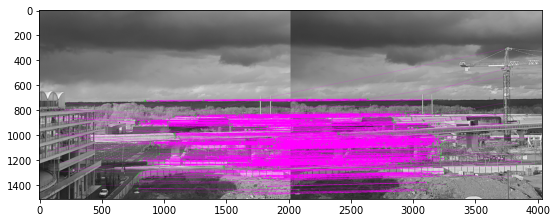

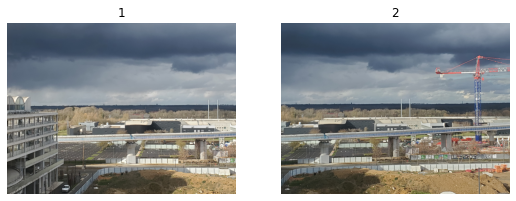

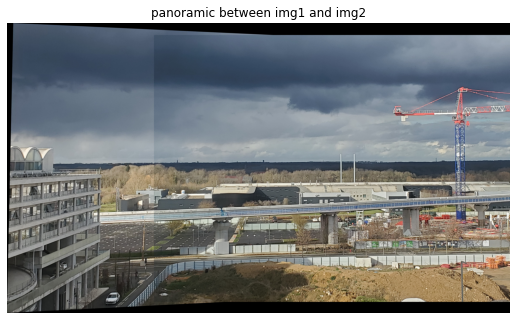

True

In [3]:
# Keypoint detection and descriptor computation algorithm
algorithm = 'ORB'
# D. Lowe's ratio test threshold
threshold = 0.8

import panorama as panorama

outputName='panorama_{}_t={}.tif'.format(algorithm,threshold)

img1c = cv.imread('palaiseau-B1sub.tif',1)
img2c = cv.imread('palaiseau-B2sub.tif',1)
#
#img2c = cv.imread('panorama.tif',1)
#img1c = cv.imread('palaiseau-B3sub.tif', 1)

img1 = cv.cvtColor(img1c, cv.COLOR_BGR2GRAY)
img2 = cv.cvtColor(img2c, cv.COLOR_BGR2GRAY)

img1c = cv.cvtColor(img1c, cv.COLOR_BGR2RGB)
img2c = cv.cvtColor(img2c, cv.COLOR_BGR2RGB)

if algorithm=='ORB':
    # Initiate ORB detector, that it will be our detector object.
    orb = cv.ORB_create(10000)

    # find the keypoints and compute the descriptors with ORB for images
    kpts1, des1 = orb.detectAndCompute(img1, None)
    kpts2, des2 = orb.detectAndCompute(img2, None)

    # Create a BFMatcher object.
    bf = cv.BFMatcher_create(cv.NORM_HAMMING)

elif algorithm=='SIFT':
    # Initiate SIFT detector, that it will be our detector object.
    sift = cv.SIFT_create(10000)

    # find the keypoints and compute the descriptors with SIFT for images
    kpts1, des1 = sift.detectAndCompute(img1, None)
    kpts2, des2 = sift.detectAndCompute(img2, None)

    # Create a BFMatcher object.
    bf = cv.BFMatcher_create(cv.NORM_L2)

elif algorithm=='AKAZE':
    # Initiate AKAZE detector, that it will be our detector object.
    akaze = cv.AKAZE_create()

    # find the keypoints and compute the descriptors with SIFT for images
    kpts1, des1 = akaze.detectAndCompute(img1, None)
    kpts2, des2 = akaze.detectAndCompute(img2, None)

    # Create a BFMatcher object.
    bf = cv.BFMatcher_create(cv.NORM_HAMMING)

else:
    print("Not implemented")


# match descriptor (returns k best matches)
matches1to2 = bf.knnMatch(des1, des2, k=2)


# draw matches
good1to2 = []
for m, n in matches1to2:
    # D. Lowe's ratio test (we eliminate a match when the second match is almost as good)
    if m.distance < threshold * n.distance: 
        good1to2.append(m)

drawimg = panorama.draw_matches(img1, kpts1, img2, kpts2, good1to2)

# find  affine transformation and panoramic view between 1 to 2
matrix1to2 = panorama.find_homography(kpts1, kpts2, good1to2)
img1to2 = panorama.warpImages(img2c, img1c, matrix1to2)

# plot image indicating paired points
plt.figure( figsize=(9,6) )
plt.imshow(drawimg)
plt.show()

# plot two original images
plt.figure( figsize=(9,6))

plt.subplot(1, 2, 1)
plt.imshow(img1c)
plt.axis('off')
plt.title('1')

plt.subplot(1, 2, 2)
plt.imshow(img2c)
plt.axis('off')
plt.title('2')

plt.show()

# plot panoramic image
plt.figure( figsize=(9,6) )

title1 = "panoramic between img1 and img2"

plt.subplot(1, 1, 1)
plt.imshow(img1to2)
plt.axis('off')
plt.title(title1)

plt.show()

img1to2 = cv.cvtColor(img1to2, cv.COLOR_BGR2RGB)
cv.imwrite("./output/"+outputName,img1to2)
cv.imwrite("./output/matches_"+outputName,drawimg)

# Question 2: ```corners.py```

The purpose of this script is to detect corners in the image, which is useful for many applications that need the matching of points.  

1. Give a short description of the main elements and analyse the effects of the different parameters (Canny, Hough,...) 
2. What is the purpose of the Gaussian blur? 
3. What other filtering could have been more appropriate? 

### Answer 1

Corner detection algorithms are based on gradients, which are very susceptible to noise. Therefore, the first element on the script is a noise reduction step, in which a Gaussian filter is applied to the image to reduce the noise. The second step is the Canny edge detection algorithm: a Sobel kernel is applied both horizontally and vertically in order to compute the gradient magnitude and direction; this is followed by non-maximal supression (every pixel is checked if it is a local maximum in its neighborhood in the direction of the gradient) and hysteresis thresholding (any edges with intensity value above an upper threshold $t_1$ are considered as edges and those bellow a lower threshold $t_2$ are discarded, edges that lie between those two thresholds are only kept if they are connected to pixels above the threshold $t_1$). The third step is the Hough line transform, that detects straight lines: in the polar coordinate system lines can be expressed by two parameters, for each point we consider the family of lines that go through it, plotting these lines in terms of the two parameters, if the curves of two different points intersect, that means they both belong to a same line; we define a minimum number of intersections needed to detect a line. Finally, the fourth step, is the actual corner detection where we search for intersections between the previously found straight lines.

With that description in mind we can analyse the effect of some of the parameters that were mentioned. On the first step (noise reduction), if we increase the standard deviation of the Gaussian filter, we get to a point where the image is smoothed too much and some of the corners are not detected; if the standard deviation is too small, noise interferes with the edge detection, and we detect many false edges. On the second step (Canny edge detection) we can vary the thresholds, increasing them we reduce the number of lines that are detected and reducing them we have the oposite effect, therefore the thresholds can be adjusted in order too try and reduce multiple detections of the same line. Finally, on the third step (Hough line transform), if we increase the number of votes needed to declare a line we detect fewer lines, and decreasing that number we detect more.
<!--- 
Canny:
https://docs.opencv.org/4.x/da/d22/tutorial_py_canny.html
https://docs.opencv.org/4.x/dd/d1a/group__imgproc__feature.html#ga04723e007ed888ddf11d9ba04e2232de
Hough lines:
https://docs.opencv.org/3.4/d9/db0/tutorial_hough_lines.html 
https://docs.opencv.org/3.4/dd/d1a/group__imgproc__feature.html#ga46b4e588934f6c8dfd509cc6e0e4545a  
--->

### Answer 2

As mentioned on the previous question, corner detection algorithms are based on gradients, which are very susceptible to noise. Therefore, it is necessary to have a noise reduction step, which is exactly the Gaussian blur: a Gaussian filter is applied to the image to reduce the noise.

### Answer 3

For a corner detection task, ideally, we would like a filtering technique that smoothes out noise and textures while retaining sharp edges and corners, therefore good alternatives to the Gaussian filter would be the median filter or the bilateral filter.
<!---or the Kuwahara filter.--->

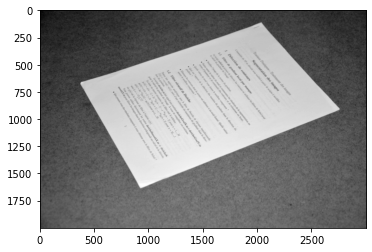

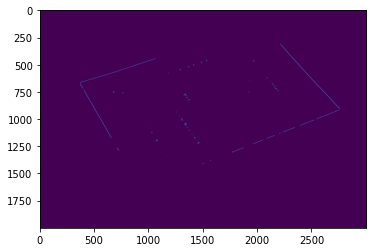

nombre de lignes :  [[[ 1.9000000e+01  2.6179938e+00]]

 [[-1.4290000e+03  2.4085543e+00]]

 [[ 7.5200000e+02  1.2566371e+00]]

 [[-1.3530000e+03  2.3736477e+00]]

 [[ 7.3800000e+02  1.2915436e+00]]

 [[ 1.8760000e+03  1.1868238e+00]]

 [[-1.4360000e+03  2.4085543e+00]]]
nombre de lignes :  7
19.0 2.6179938
-1429.0 2.4085543
752.0 1.2566371
-1353.0 2.3736477
738.0 1.2915436
1876.0 1.1868238
-1436.0 2.4085543
365 671
2038 128
2502 643
2012 136
361 664
2077 171
601 595
2053 178
929 1647
2745 913
2758 908
2045 125
2641 787
2085 169
2752 911
nbr intersects 15


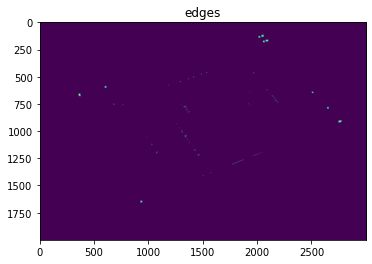

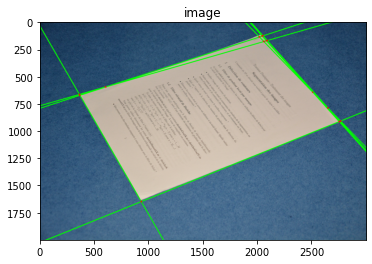

True

In [4]:
# PARAMETERS
gaussianStd = 0 # Standard deviation of the Gaussian filter (if 0 it is computed based on the kernel size)
t1 = 180 # Canny's hysteresis thresholding upper threshold
t2 = 150 # 20 # Canny's hysteresis thresholding lower threshold
houghT = 110 # 100 # Hough's threshold on the number of votes needed to declare a line

img = cv.imread('f7.tif') 
imrvb=img.copy()


gray = cv.cvtColor(img,cv.COLOR_BGR2GRAY)     

# 1. NOISE REDUCTION
gaussianSize = 9 # Size of the Gaussian filter
kernel = np.ones((gaussianSize,gaussianSize),np.uint8)
#gray = cv.morphologyEx(gray, cv.MORPH_CLOSE, kernel)

gray = cv.GaussianBlur(gray,(gaussianSize,gaussianSize),gaussianStd)

#gray = cv.medianBlur(gray, ksize=13)

plt.figure()
plt.imshow(gray, cmap='gray')
plt.show()
  
# 2. CANNY EDGE DETECTION
sobelAperture = 3 # Canny's sobel filter aperture
edges = cv.Canny(gray, t2, t1, apertureSize = sobelAperture) 
  
plt.figure('Canny edges')
plt.imshow(edges)
plt.show()

# 3. HOUGH LINES
ro = 1 # distance resolution
theta = 2*np.pi/180 # angle resolution
lines = cv.HoughLines(edges, ro, theta, houghT) 

nbrlines = lines.shape[0]

print('nombre de lignes : ', lines)

print('nombre de lignes : ', nbrlines)


for line1 in range(nbrlines):  
    r1,theta1 = lines[line1][0]
    print(r1,theta1)

# 4. CORNER DETECTION
nbrintersects=0

fichier = open("data.txt", "w")
corners = []

for line1 in range(nbrlines):  
    r1,theta1 = lines[line1][0]
    
    a1 = np.cos(theta1) 
    b1 = np.sin(theta1)
    c1 = -r1
    
    x1 = int(a1*r1 + 4000*(-b1)) 
    y1 = int(b1*r1 + 4000*(a1)) 
    x2 = int(a1*r1 - 4000*(-b1)) 
    y2 = int(b1*r1 - 4000*(a1)) 
          
    (a,b,c)=125+125*np.random.rand(3, 1)
    a=int(0)
    b=int(255)
    c=int(0)
    cv.line(imrvb,(x1,y1), (x2,y2), (a,b,c),7) 
    cv.line(edges,(x1,y1), (x2,y2), (a,b,c),7) 
    
    x1=int(a1+5)
    y1=int(b1+5)
    x2=int(a1-5)
    y2=int(b1-5)
    
    a=255
    b=0
    c=0
    
    cv.line(imrvb,(x1,y1), (x2,y2), (a,b,c),5) 
    cv.line(edges,(x1,y1), (x2,y2), (a,b,c),5) 
#
#    plt.figure()
#    plt.title('edges hough')
#    plt.imshow(edges)
#    plt.show()
#
#    plt.figure()
#    plt.title('image hough')
#    plt.imshow(imrvb)
#    plt.show()


    for line2 in range(line1):
        
        r2,theta2 = lines[line2][0]

        a2 = np.cos(theta2) 
        b2 = np.sin(theta2)
        c2 = -r2
    
        
        X =   b1 * c2 - c1 * b2
        Y =   c1 * a2 - a1 * c2
        Z =   a1 * b2 - b1 * a2
        

        if Z != 0:
            
            X=X/Z
            Y=Y/Z   
            
            if 0 < X < img.shape[1]:
                if 0 < Y < img.shape[0]:
                                
                    nbrintersects += 1
                    
                    print(int(X),int(Y))
                    
                    fichier.write(str ( int ( X ) ) )
                    fichier.write (" ")
                    fichier.write(str ( int ( Y ) ) ) 
                    fichier.write("\n")

                    corners.append([X,Y])
                    
                    x1=int(X+5)
                    y1=int(Y+5)
                    x2=int(X-5)
                    y2=int(Y-5)
                
                    a=255
                    b=0
                    c=0
                
                    cv.line(imrvb,(x1,y1), (x2,y2), (a,b,c),5) 
                    cv.line(edges,(x1,y1), (x2,y2), (a,b,c),5) 
        
                    x1=int(X-5)
                    y1=int(Y+5)
                    x2=int(X+5)
                    y2=int(Y-5)
        
                    cv.line(imrvb,(x1,y1), (x2,y2), (a,b,c),5) 
                    cv.line(edges,(x1,y1), (x2,y2), (a,b,c),5) 

fichier.close()


print('nbr intersects',nbrintersects)

plt.figure()
plt.title('edges')
plt.imshow(edges)
plt.show()

plt.figure()
plt.title('image')
plt.imshow(imrvb)
plt.show()

cv.imwrite('./output/linesDetected_gaussianStd{}_t1{}_t2{}_sobel{}_hought{}.jpg'.format(gaussianStd, t1, t2, sobelAperture, houghT), imrvb) 

# Question 3: ```redresA4.py```

1. Apply this script to the image of a building 
1. Test the robustness by adding some outliers 
1. Replace the manually selected points with the output of corners.py. Comment.

## Answer 1

The script will be applied to a photo I took of a building in order to correct its perspective. We can see that the algorithm yields good results.

## Answer 2

In order to test the robustness of the method we are going to use the image *f7.jpg*, for which we have defined 4 keypoints. First of all, running the code without outliers we observe that the perspective of the A4 sheet is perfectly corrected, with 1 outlier we can still correct the perspective, however with 2 outliers the result gets distorted.

## Answer 3

Still using the image *f7.jpg*, we will use the points detected by the corner detection algorithm instead of manually selecting them. First of all, a pre-processing of the detected points is needed, since the corner detection algorithm detected multiple points corresponding to the same corners, therefore we will only use the uppermost, leftmost, rightmost and bottommost points, doing so we obtained good results. Using the points detected by a corner detection method is useful to automate the process of perspective correction, however, care must be taken in order to obtain the right matches between the target keypoints and the detected keypoints.

In [5]:
from matplotlib.pyplot import imshow, show, subplot, title, axis, figure, plot


# draw matches
def draw_matches(img2, kpt2, matches,rayon):

    h2, w2 = img2.shape[:2]

    # Create a blank image with the size of the first image + second image
    new_img = np.zeros((h2, w2, 3), dtype='uint8')
#    new_img[:h2, :w2, :] = np.dstack([img2, img2, img2])
    new_img[:h2, :w2, :] = np.dstack([img2])

    # extract the match keypoints
    
    for m in matches:
        (x2, y2) = kpt2[m.trainIdx].pt

        # Draw circles on the keypoints
        cv.circle(new_img, (int(x2), int(y2)), rayon, (255, 255, 255), 1)

    return new_img


def warpImages(kp, img, M):
    # get the corner coordinates of the "query" and "train" image
    h=kp[2].pt[1]
    w=kp[2].pt[0]
            
    new_img = cv.warpPerspective(img, M,(np.int32(w),np.int32(h)))

    return new_img


def find_homography(kpt1, kpt2, matches):
    # Find an Homography matrix between two pictures
    # Transforming keypoints to list of points
   
    dst_pts = np.float32([kpt1[m.queryIdx].pt for m in matches]).reshape(-1, 1, 2)
    src_pts = np.float32([kpt2[m.trainIdx].pt for m in matches]).reshape(-1, 1, 2)
 
    # Compute a rigid transformation (only scale + rotation + translation) /affine transformation
    affine_matrix, rigid_mask = cv.estimateAffinePartial2D(src_pts, dst_pts)    
    affine_row = [0, 0, 1]
    affine_matrix = np.vstack((affine_matrix, affine_row))
    
    M=affine_matrix
    print(M)

    # Compute an homography
        
    M, mask = cv.findHomography(src_pts, dst_pts,cv.RANSAC,3)

    print(M)
    print(mask)
    
    return M
    #return affine_matrix

pts1 [[10, 200], [1400, 200], [1400, 920], [10, 920]]
pts2 [[200, 235], [1200, 560], [1230, 1180], [150, 1120]]
points feuille
(10.0, 200.0)
(1400.0, 200.0)
(1400.0, 920.0)
(10.0, 920.0)
points image
(200.0, 235.0)
(1200.0, 560.0)
(1230.0, 1180.0)
(150.0, 1120.0)
matches
10.0 200.0 200.0 235.0
1400.0 200.0 1200.0 560.0
1400.0 920.0 1230.0 1180.0
10.0 920.0 150.0 1120.0
points


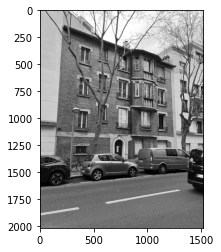

[[   1.25720746    0.40859243 -337.46071227]
 [  -0.40859243    1.25720746  -13.72526851]
 [   0.            0.            1.        ]]
[[ 9.05885947e-01  5.21989546e-02 -1.83881655e+02]
 [-3.35189545e-01  8.52755739e-01  5.78860819e+01]
 [-3.17505860e-04  8.39575765e-05  1.00000000e+00]]
[[1]
 [1]
 [1]
 [1]]


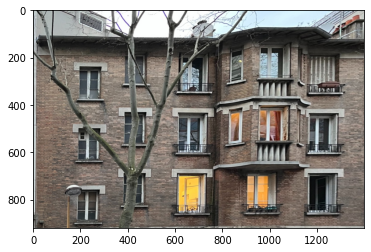

True

In [6]:
# QUESTION 1
Noutliers=0

# Read images
img1c = cv.imread('./myImages/myImage6.jpg', 1) # importing the image
img1 = cv.cvtColor(img1c, cv.COLOR_BGR2GRAY) # converting to gray
img1c = cv.cvtColor(img1c, cv.COLOR_BGR2RGB) # color: converting to matplotlib formar


# Données pour l'image redressée (expected position of keypoints on the rectified image)
resol=1
x1=10
y1=200
sizeH=1400
sizeV=920
x2=resol*sizeH
y2=resol*sizeV

pts1=[]
pts1.append([x1,y1])
pts1.append([x2,y1])
pts1.append([x2,y2])
pts1.append([x1,y2])

# Why divide by four??????? 
demil=(x1+x2)/4
demih=(y1+y2)/4

for i in range(Noutliers):
    pts1.append([demil+demil*np.random.randn(),demih+demih*np.random.randn()])


print('pts1',pts1)


# données pour f6.jpg
# x1=248
# y1=949
# x2=1450
# y2=924
# x3=1541
# y3=2592
# x4=225
# y4=2621


# données pour f7.jpg (handpicked keypoints corresponding to those of the rectified image)
x1=200
y1=235
x2=1200
y2=560
x3=1230
y3=1180
x4=150
y4=1120


demil=(x1+x2+x3+x4)/8
demih=(y1+y2+y3+y4)/8

pts2=[]
pts2.append([x1,y1])
pts2.append([x2,y2])
pts2.append([x3,y3])
pts2.append([x4,y4])

for i in range(Noutliers):
    pts2.append([demil+demil*np.random.randn(),demih+demih*np.random.randn()])

print('pts2', pts2)


kp1 = [cv.KeyPoint(x[0], x[1], 1) for x in pts1]
kp2 = [cv.KeyPoint(x[0], x[1], 1) for x in pts2]

print('points feuille')
for i in range (len(pts1)):
    print(kp1[i].pt)

print('points image')
for i in range (len(pts2)):
    print(kp2[i].pt)

goodMatches=[]
for i in range(len(pts1)):
    m=cv.DMatch(i,i,0)
    goodMatches.append(m)

print('matches')
for m in goodMatches:
    (x1, y1) = kp1[m.queryIdx].pt
    (x2, y2) = kp2[m.trainIdx].pt
    print ( x1,y1,x2,y2)
print('points')

figure()
kp_img = cv.drawKeypoints(img1, kp2, None, color=(0, 255, 0))
imshow(kp_img)
show()

#
## find  affine transformation and panoramic view between 1 to 2
matrix1to2 = find_homography(kp1, kp2, goodMatches)
img1to2 = warpImages(kp1, img1c, matrix1to2)
#

figure()
imshow(img1to2)
show()

cv.imwrite('./output/redres_myImage.jpg'.format(Noutliers), img1to2) 

pts1 [[0, 0], [1050, 0], [1050, 1485], [0, 1485], [478.8332997887409, 376.544450377845]]
pts2 [[2030, 110], [2750, 904], [920, 1638], [363, 663], [1003.3094762470236, 824.63555144683]]
points feuille
(0.0, 0.0)
(1050.0, 0.0)
(1050.0, 1485.0)
(0.0, 1485.0)
(478.83331298828125, 376.5444641113281)
points image
(2030.0, 110.0)
(2750.0, 904.0)
(920.0, 1638.0)
(363.0, 663.0)
(1003.3094482421875, 824.6355590820312)
matches
0.0 0.0 2030.0 110.0
1050.0 0.0 2750.0 904.0
1050.0 1485.0 920.0 1638.0
0.0 1485.0 363.0 663.0
478.83331298828125 376.5444641113281 1003.3094482421875 824.6355590820312
points


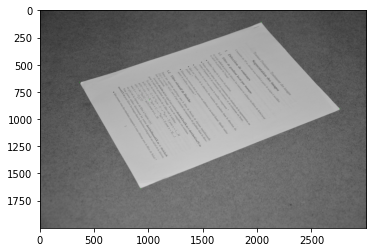

[[-1.42204713e-01  4.65738199e-01  2.37444365e+02]
 [-4.65738199e-01 -1.42204713e-01  9.61091062e+02]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]
[[ 3.85189924e-01  1.16114214e+00 -9.09661180e+02]
 [-7.63172919e-01  6.92045971e-01  1.47311597e+03]
 [-6.13465327e-06  1.75934908e-04  1.00000000e+00]]
[[1]
 [1]
 [1]
 [1]
 [0]]


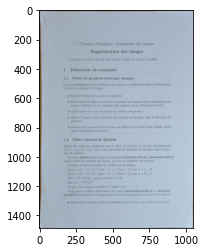

True

In [7]:
# QUESTION 2
Noutliers=1

# Read images
img1c = cv.imread('f7.jpg', 1) # importing the image
img1 = cv.cvtColor(img1c, cv.COLOR_BGR2GRAY) # converting to gray
img1c = cv.cvtColor(img1c, cv.COLOR_BGR2RGB) # color: converting to matplotlib formar


# Données pour l'image redressée (expected position of keypoints on the rectified image)
resol=5
x1=0
y1=0
sizeH=210
sizeV=297
x2=resol*sizeH
y2=resol*sizeV

pts1=[]
pts1.append([x1,y1])
pts1.append([x2,y1])
pts1.append([x2,y2])
pts1.append([x1,y2])

# Why divide by four??????? 
demil=(x1+x2)/4
demih=(y1+y2)/4

for i in range(Noutliers):
    pts1.append([demil+demil*np.random.randn(),demih+demih*np.random.randn()])


print('pts1',pts1)


# données pour f6.jpg
# x1=248
# y1=949
# x2=1450
# y2=924
# x3=1541
# y3=2592
# x4=225
# y4=2621


# données pour f7.jpg (handpicked keypoints corresponding to those of the rectified image)
x1=2030
y1=110
x2=2750
y2=904
x3=920
y3=1638
x4=363
y4=663


demil=(x1+x2+x3+x4)/8
demih=(y1+y2+y3+y4)/8

pts2=[]
pts2.append([x1,y1])
pts2.append([x2,y2])
pts2.append([x3,y3])
pts2.append([x4,y4])

for i in range(Noutliers):
    pts2.append([demil+demil*np.random.randn(),demih+demih*np.random.randn()])

print('pts2', pts2)


kp1 = [cv.KeyPoint(x[0], x[1], 1) for x in pts1]
kp2 = [cv.KeyPoint(x[0], x[1], 1) for x in pts2]

print('points feuille')
for i in range (len(pts1)):
    print(kp1[i].pt)

print('points image')
for i in range (len(pts2)):
    print(kp2[i].pt)

goodMatches=[]
for i in range(len(pts1)):
    m=cv.DMatch(i,i,0)
    goodMatches.append(m)

print('matches')
for m in goodMatches:
    (x1, y1) = kp1[m.queryIdx].pt
    (x2, y2) = kp2[m.trainIdx].pt
    print ( x1,y1,x2,y2)
print('points')

figure()
kp_img = cv.drawKeypoints(img1, kp2, None, color=(0, 255, 0))
imshow(kp_img)
show()

#
## find  affine transformation and panoramic view between 1 to 2
matrix1to2 = find_homography(kp1, kp2, goodMatches)
img1to2 = warpImages(kp1, img1c, matrix1to2)
#

figure()
imshow(img1to2)
show()

cv.imwrite('./output/redres_outliers{}.jpg'.format(Noutliers), img1to2) 

pts1 [[0, 0], [1050, 0], [1050, 1485], [0, 1485]]
pts2 [[2045.7695, 125.98877], [2758.5247, 908.81506], [929.42883, 1647.8177], [361.47333, 664.0901]]
points feuille
(0.0, 0.0)
(1050.0, 0.0)
(1050.0, 1485.0)
(0.0, 1485.0)
points image
(2045.76953125, 125.98876953125)
(2758.524658203125, 908.8150634765625)
(929.4288330078125, 1647.8177490234375)
(361.47332763671875, 664.090087890625)
matches
0.0 0.0 2045.76953125 125.98876953125
1050.0 0.0 2758.524658203125 908.8150634765625
1050.0 1485.0 929.4288330078125 1647.8177490234375
0.0 1485.0 361.47332763671875 664.090087890625
points


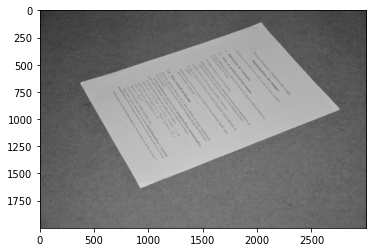

[[ 6.67709011e-01  7.33351681e-01 -1.45837283e+03]
 [-7.33351681e-01  6.67709011e-01  1.41614469e+03]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]
[[ 3.68981838e-01  1.15493995e+00 -9.00361265e+02]
 [-7.60694953e-01  6.92604773e-01  1.46894613e+03]
 [-1.94985240e-05  1.81908846e-04  1.00000000e+00]]
[[1]
 [1]
 [1]
 [1]]


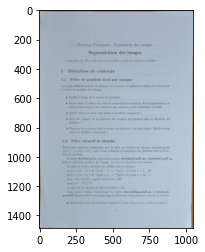

In [8]:
# QUESTION 3

# Read images
img1c = cv.imread('f7.jpg', 1) # importing the image
img1 = cv.cvtColor(img1c, cv.COLOR_BGR2GRAY) # converting to gray
img1c = cv.cvtColor(img1c, cv.COLOR_BGR2RGB) # color: converting to matplotlib formar


Noutliers=0

# Données pour l'image redressée (expected position of keypoints on the rectified image)
resol=5
x1=0
y1=0
sizeH=210
sizeV=297
x2=resol*sizeH
y2=resol*sizeV

pts1=[]
pts1.append([x1,y1])
pts1.append([x2,y1])
pts1.append([x2,y2])
pts1.append([x1,y2])

# Why divide by four??????? 
demil=(x1+x2)/4
demih=(y1+y2)/4

for i in range(Noutliers):
    pts1.append([demil+demil*np.random.randn(),demih+demih*np.random.randn()])


print('pts1',pts1)


# données pour f6.jpg
# x1=248
# y1=949
# x2=1450
# y2=924
# x3=1541
# y3=2592
# x4=225
# y4=2621


# données pour f7.jpg (handpicked keypoints corresponding to those of the rectified image)
# x1=2030
# y1=110
# x2=2750
# y2=904
# x3=920
# y3=1638
# x4=363
# y4=663

# Selecting the extreme points among those detected by the corner detection algorithm
cornersArray = np.array( corners )
pt1 = np.argmin( cornersArray[:,1] )
pt2 = np.argmax( cornersArray[:,0] )
pt3 = np.argmax( cornersArray[:,1] )
pt4 = np.argmin( cornersArray[:,0] )
x1, y1 = corners[pt1]
x2, y2 = corners[pt2]
x3, y3 = corners[pt3]
x4, y4 = corners[pt4]


demil=(x1+x2+x3+x4)/8
demih=(y1+y2+y3+y4)/8

pts2=[]
pts2.append([x1,y1])
pts2.append([x2,y2])
pts2.append([x3,y3])
pts2.append([x4,y4])

for i in range(Noutliers):
    pts2.append([demil+demil*np.random.randn(),demih+demih*np.random.randn()])

print('pts2', pts2)


kp1 = [cv.KeyPoint(x[0], x[1], 1) for x in pts1]
kp2 = [cv.KeyPoint(x[0], x[1], 1) for x in pts2]

print('points feuille')
for i in range (len(pts1)):
    print(kp1[i].pt)

print('points image')
for i in range (len(pts2)):
    print(kp2[i].pt)

goodMatches=[]
for i in range(len(pts1)):
    m=cv.DMatch(i,i,0)
    goodMatches.append(m)

print('matches')
for m in goodMatches:
    (x1, y1) = kp1[m.queryIdx].pt
    (x2, y2) = kp2[m.trainIdx].pt
    print ( x1,y1,x2,y2)
print('points')

figure()
kp_img = cv.drawKeypoints(img1, kp2, None, color=(0, 255, 0))
imshow(kp_img)
show()

#
## find  affine transformation and panoramic view between 1 to 2
matrix1to2 = find_homography(kp1, kp2, goodMatches)
img1to2 = warpImages(kp1, img1c, matrix1to2)
#

figure()
imshow(img1to2)
show()